# 6.6 Sourcing and Analyzing Time Series Data

#### Table of Contents

### 1. Importing Libraries

### 2. Importing Data

### 3. Subsetting, Wrangling and Cleaning Time-Series Data

### 4. Line Chart of the Data

### 5. Decompose the Data

### 6. Stationarity Testing: Dickey-Fuller Test

### 7. Stationarity: Round of Differencing

## 1. Import Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This mis a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate

plt.style.use('fivethirtyeight') # This is the styling option for how these plots will appear.

## 2. Importing Data

In [2]:
#Configure API key 
quandl.ApiConfig.api_key = 't1YkWXGWpEDQWazuMPeh'

In [3]:
#Importing the Federal Reserve Economic Data "Excess Reserves of Depositry Institutions" variable.
data = quandl.get('FRED/EXCSRESNW')

In [4]:
data.head()

,Value
Date,
1984-02-08,1167.0
1984-02-15,1167.0
1984-02-22,674.0
1984-02-29,674.0
1984-03-07,725.0


In [5]:
data.tail()

,Value
Date,
2020-08-12,2751124.0
2020-08-19,2821740.0
2020-08-26,2821740.0
2020-09-02,2854690.0
2020-09-09,2854690.0


In [6]:
data.shape

(1910, 1)

In [7]:
type(data)

pandas.core.frame.DataFrame

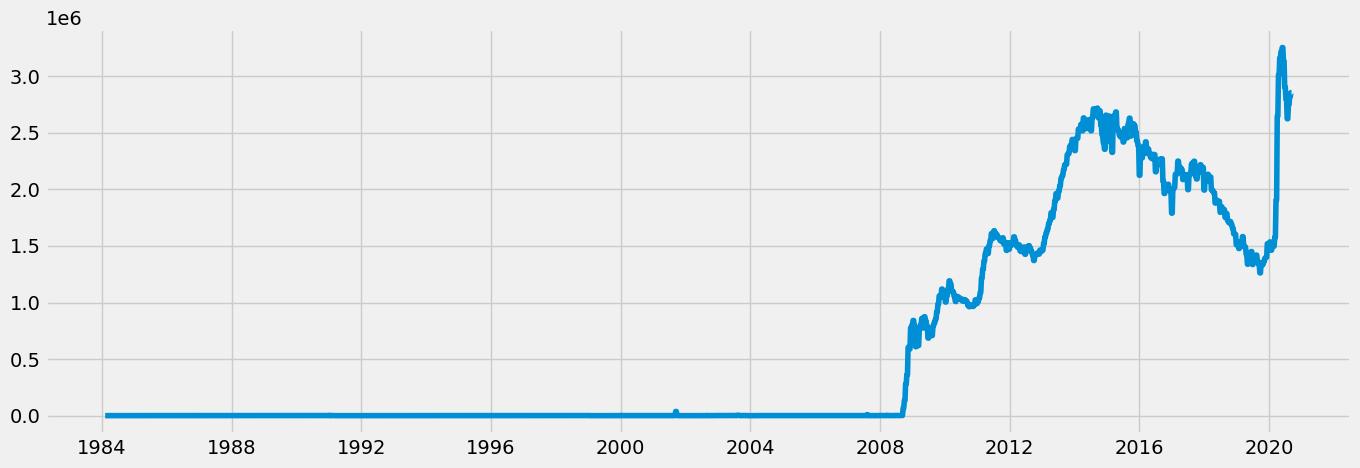

In [8]:
#Plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

#### There is a clear divide in the data when banks began carrying more excess reserves which was right around September 2008 after the sub-prime crisis happened and the fall of the Lehman Brothers bank.  The reserves were not Zero pre-2008, so it may be worth looking at these values by themselves.

## 3. Subsetting, Wrangling and Cleaning Time-Series Data

In [9]:
#Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

##### Subset of Time Series POST September 2008

In [10]:
#Show the data POST Septmeber 2008
data_sub_post = data_2.loc[(data_2['Date'] >= '2008-09-01') & (data_2['Date'] < '2020-09-30')]

In [11]:
data_sub_post.shape

(628, 2)

In [12]:
data_sub_post.head()

,Date,Value
1282,2008-09-03,2270.0
1283,2008-09-10,2270.0
1284,2008-09-17,67864.0
1285,2008-09-24,67864.0
1286,2008-10-01,135280.0


In [13]:
#Set the "Date" column as the index
from datetime import datetime

data_sub_post['datetime'] = pd.to_datetime(data_sub_post['Date']) # Create a datetime column from "Date.""
data_sub_post = data_sub_post.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub_post.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub_post.head()

,Value
datetime,
2008-09-03,2270.0
2008-09-10,2270.0
2008-09-17,67864.0
2008-09-24,67864.0
2008-10-01,135280.0


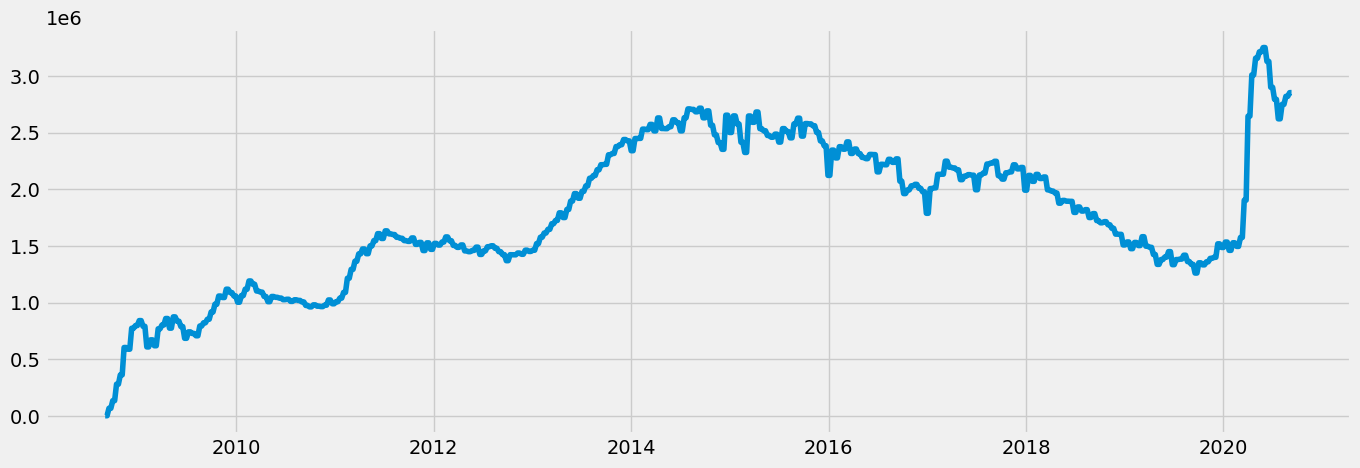

In [14]:
#Plot the new data set for post Sept 2008
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub_post)

In [15]:
#Check for missing values
data_sub_post.isnull().sum() 

Value    0
dtype: int64

In [16]:
#Check for duplicates
dups = data_sub_post.duplicated()
dups.sum()

314

In [17]:
data_dups_post = data_sub_post.drop_duplicates()

In [18]:
data_dups_post

,Value
datetime,
2008-09-03,2270.0
2008-09-17,67864.0
2008-10-01,135280.0
2008-10-15,280972.0
2008-10-29,362890.0
...,...
2020-07-08,2795785.0
2020-07-22,2623526.0
2020-08-05,2751124.0


In [19]:
data_dups_post.shape

(314, 1)

In [20]:
#Check for duplicates after cleaning
no_dups_post = data_dups_post.duplicated()
no_dups_post.sum()

0

##### Subset of Time Series PRE September 2008

In [21]:
#Show the data PRE September 2008
data_sub_pre = data_2.loc[(data_2['Date'] >= '1984-12-31') & (data_2['Date'] < '2008-09-01')]

In [22]:
data_sub_pre.shape

(1235, 2)

In [23]:
data_sub_pre.head()

,Date,Value
47,1985-01-02,1170.0
48,1985-01-09,680.0
49,1985-01-16,680.0
50,1985-01-23,730.0
51,1985-01-30,730.0


In [24]:
data_sub_pre.describe()

,Value
count,1235.000000
mean,1338.419433
std,1584.660111
min,307.000000
25%,954.000000
50%,1187.000000
75%,1507.000000
max,38057.000000


In [25]:
#Set the "Date" column as the index
from datetime import datetime

data_sub_pre['datetime'] = pd.to_datetime(data_sub_pre['Date']) # Create a datetime column from "Date.""
data_sub_pre = data_sub_pre.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub_pre.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub_pre.head()

,Value
datetime,
1985-01-02,1170.0
1985-01-09,680.0
1985-01-16,680.0
1985-01-23,730.0
1985-01-30,730.0


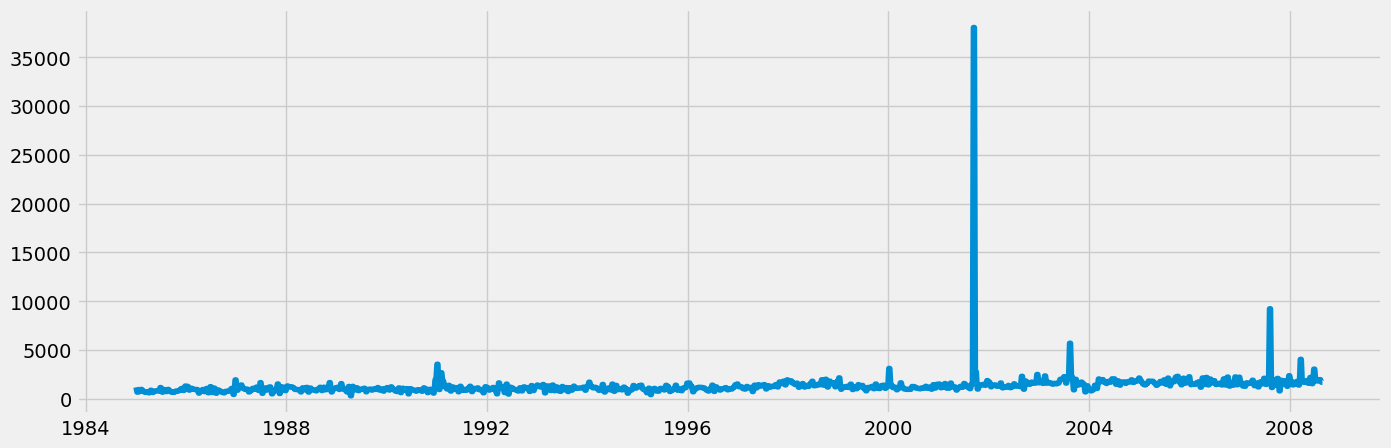

In [26]:
#Plot the new data set for pre Sept 2008
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub_pre)

In [27]:
#Calculate IQR for Value Column to locate outliers
Q1 = data_sub_pre['Value'].quantile(0.25)
Q3 = data_sub_pre['Value'].quantile(0.75)
IQR = Q3-Q1

In [28]:
#Identify the Outliers
threshold = 1.5
outliers = data_sub_pre[(data_sub_pre['Value'] < Q1 - threshold * IQR) | (data_sub_pre['Value'] > Q3 + threshold * IQR)]

In [29]:
#Delete extreme values
data_pre_extreme = data_sub_pre.drop(outliers.index)

In [30]:
data_pre_extreme.shape

(1213, 1)

In [31]:
data_pre_extreme.describe()

,Value
count,1213.000000
mean,1235.906018
std,384.604951
min,307.000000
25%,951.000000
50%,1175.000000
75%,1492.000000
max,2332.000000


In [32]:
#Check for missing values
data_pre_extreme.isnull().sum() 

Value    0
dtype: int64

In [33]:
#Check for duplicates
dups = data_pre_extreme.duplicated()
dups.sum()

719

In [34]:
data_dups_pre = data_pre_extreme.drop_duplicates()

In [35]:
data_dups_pre.shape

(494, 1)

In [36]:
#Check for duplicates after cleaning
no_dups_pre = data_dups_pre.duplicated()
no_dups_pre.sum()

0

## 4. Line Chart of Data

##### Line Chart for values Pre Sept 2008

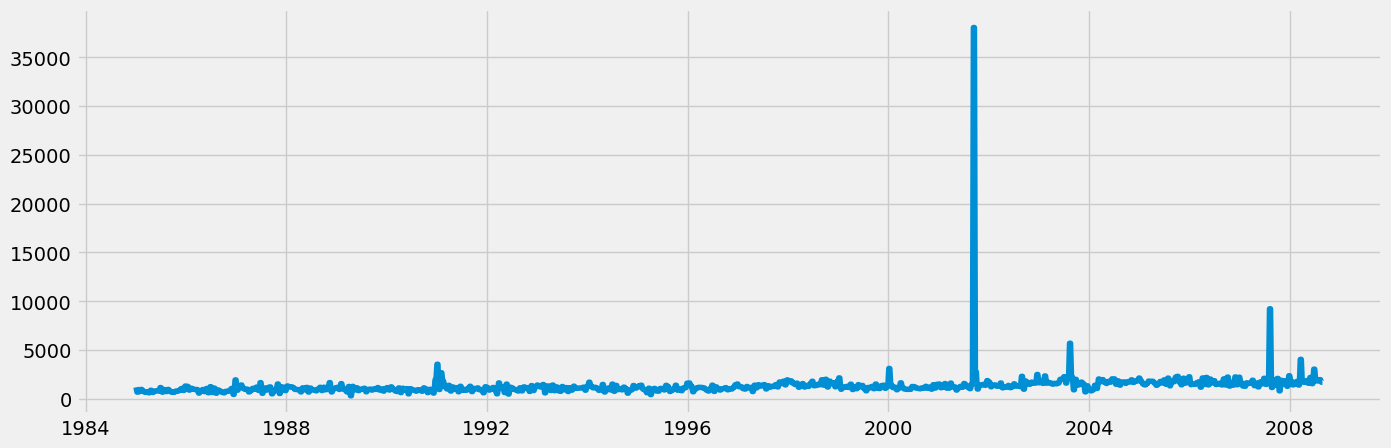

In [37]:
#Plot the new data set for pre Sept 2008 WITH Extreme Outliers
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub_pre)

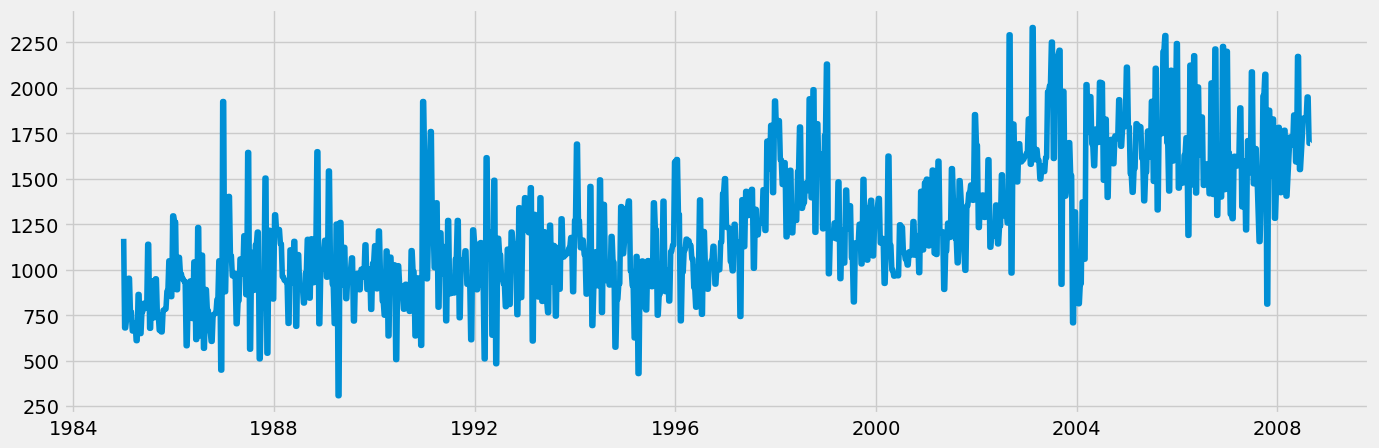

In [38]:
#Plot the new data set for pre Sept 2008 WITHOUT Extreme Outliers
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_pre_extreme)

##### Line Chart for Values Post Sept 2008

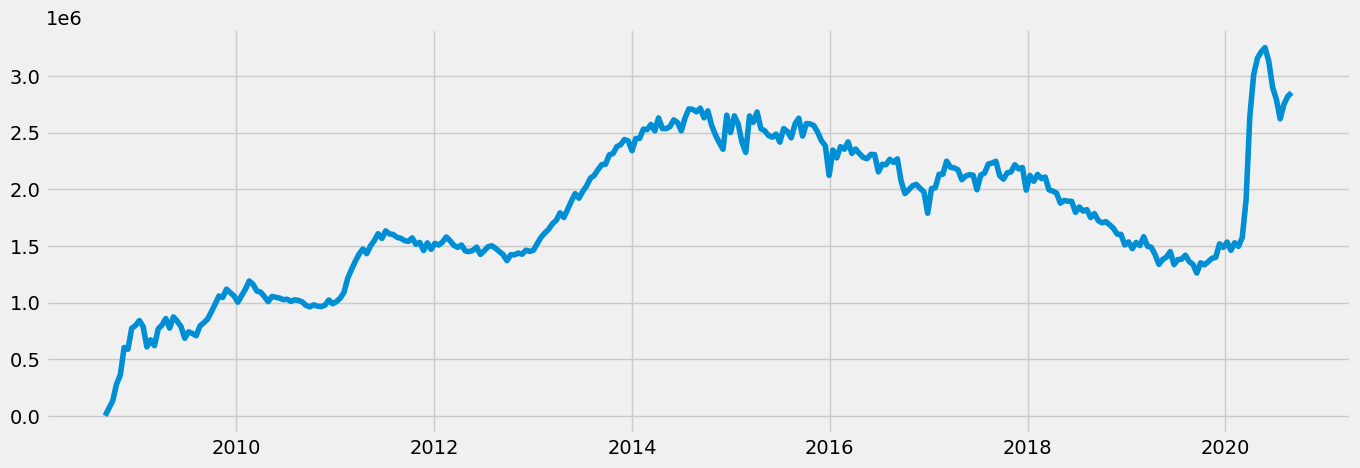

In [39]:
#Plot the new data set for post Sept 2008
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_dups_post)

#### Observations: It's subtle, but the lines are a little smoother after the dups were removed.  It's particularly noticable in the large rises

## 5. Decompose the Data's Components

##### Decomposition Post Sept 2008

In [40]:
#Decompose the time series using an additive model
decomposition_post = sm.tsa.seasonal_decompose(data_dups_post, model='additive')

In [41]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

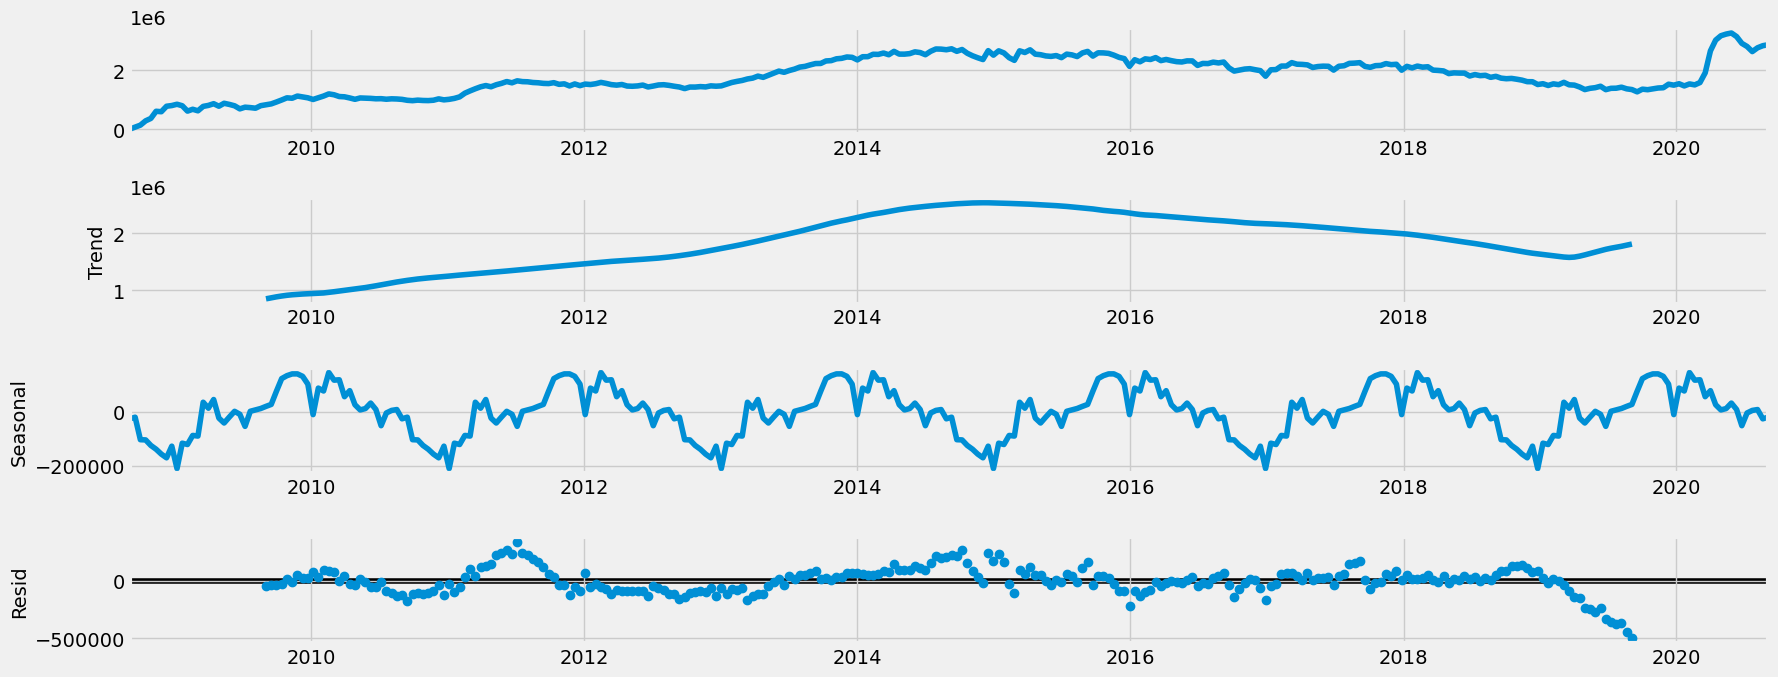

In [42]:
#Plot the separate components
decomposition_post.plot()
plt.show()

#### Analysis:  As shown by the second line, the trend is realtively similar to the acutal data line.  This would mean that there isn't much 'noise' in the data.  The excess bank reserves seem to rise to about 2015, trend downwards until the end of 2019 and then begin to rise again.

#### We can see the seasonality tends to fall at the beginning of the even numbered years and rise at the beginnins of the odd number years.  In between the flucuations are of varying degrees, which would make sense as excess reserves at banks likely have several different contributing factors that affect the amounts.

#### There are varying flucuations in the residual as it doesn't appear to be any straight linear display here.  Small peak in 2011 and a sharp decline in 2019.  The 2019 portion might have something to do with the COVID outbreak.

##### Decomposition Pre Sept 2008

In [43]:
#Decompose the time series using an additive model: WITH Outliers
decomposition_pre = sm.tsa.seasonal_decompose(data_sub_pre, model='additive')

In [44]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

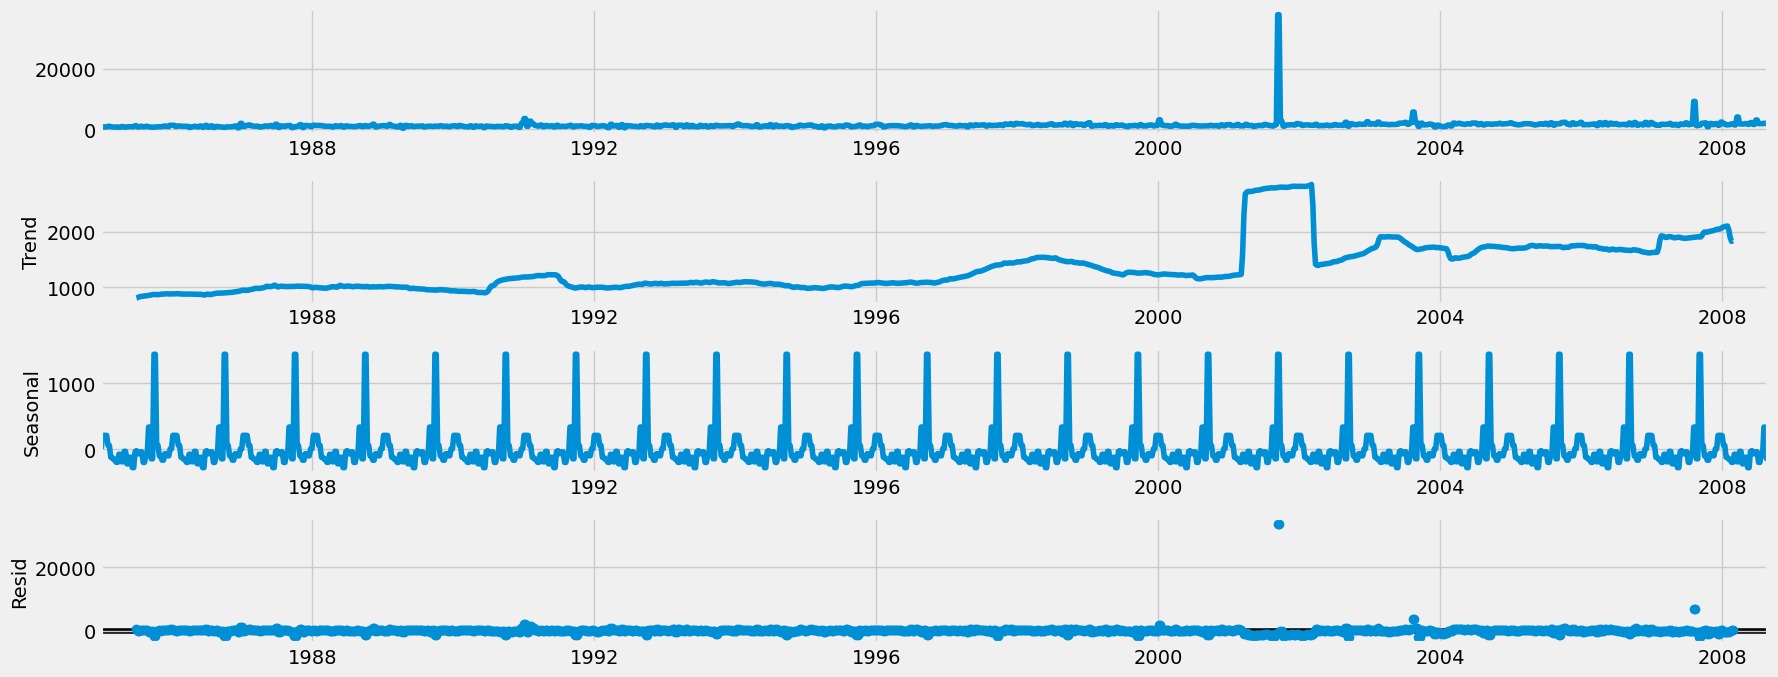

In [45]:
#Plot the separate components
decomposition_pre.plot()
plt.show()

#### Analysis:  As shown by the second line, the trend is realtively similar to the acutal data line, with the exception to the notable spike occuring near 2001-2002.  This could be related to the dot com incident and why excess reserves were increased so much. 

#### We can see the seasonality tends to repeat much mroe frequently pre-2008, with a large spike and immediate fall near the end of every year.

#### There does not seem to be any real noise in the data other than the point in 2001-2002 and near the end of 2007.  

## 6. Stationarity Testing: Dickey-Fuller Test

##### Stationarity Test: Post Sept 2008

In [46]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    
    #Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_dups_post['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.684453
p-value                          0.439140
Number of Lags Used             14.000000
Number of Observations Used    299.000000
Critical Value (1%)             -3.452411
Critical Value (5%)             -2.871255
Critical Value (10%)            -2.571947
dtype: float64


#### Unit Root: Random Jump that cannot be explained by variation in the data.

#### NULL Hypothesis: There exists a Unit Root.

#### Alternative Hypothesis: There are no Unit Roots.

#### The Test-Statistic is larger than all critical values, thus we cannot reject the Null Hypothesis.  This means there does exist a Unit Root and the data does NOT have stationarity

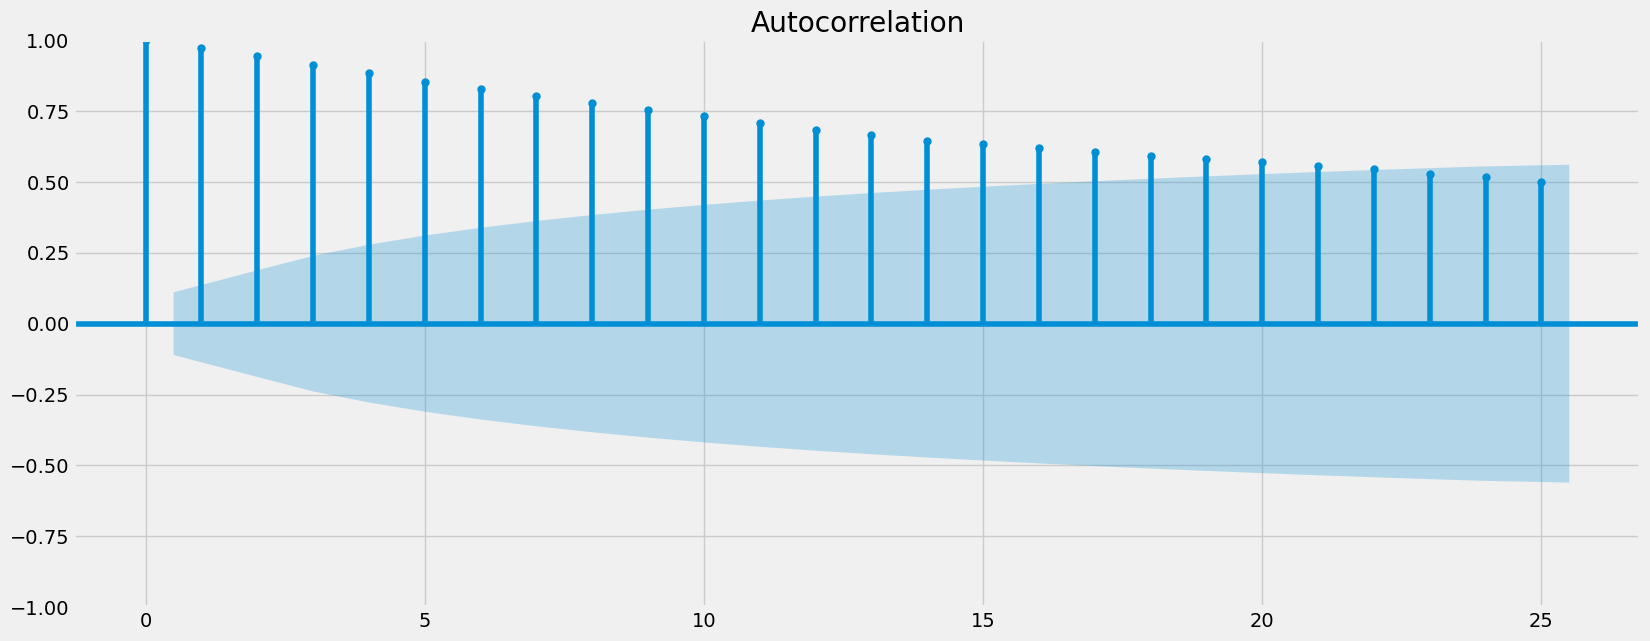

In [47]:
#Plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_dups_post)
plt.show()

#### Autocorrelation:  Due to the large number of lines that exist outside the confidence interval (blue-shaded area), we can deduce from this that the data does NOT have stationarity

##### Stationarity Test: Pre Sept 2008

In [48]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    
    #Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub_pre['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -5.747278e+00
p-value                        6.080212e-07
Number of Lags Used            2.200000e+01
Number of Observations Used    1.212000e+03
Critical Value (1%)           -3.435757e+00
Critical Value (5%)           -2.863928e+00
Critical Value (10%)          -2.568041e+00
dtype: float64


#### Unit Root: Random Jump that cannot be explained by variation in the data.

#### NULL Hypothesis: There exists a Unit Root.

#### Alternative Hypothesis: There are no Unit Roots.

#### The Test-Statistic is smaller than all critical values, thus we can reject the Null Hypothesis.  This means there does not exist a Unit Root and the data does have stationarity

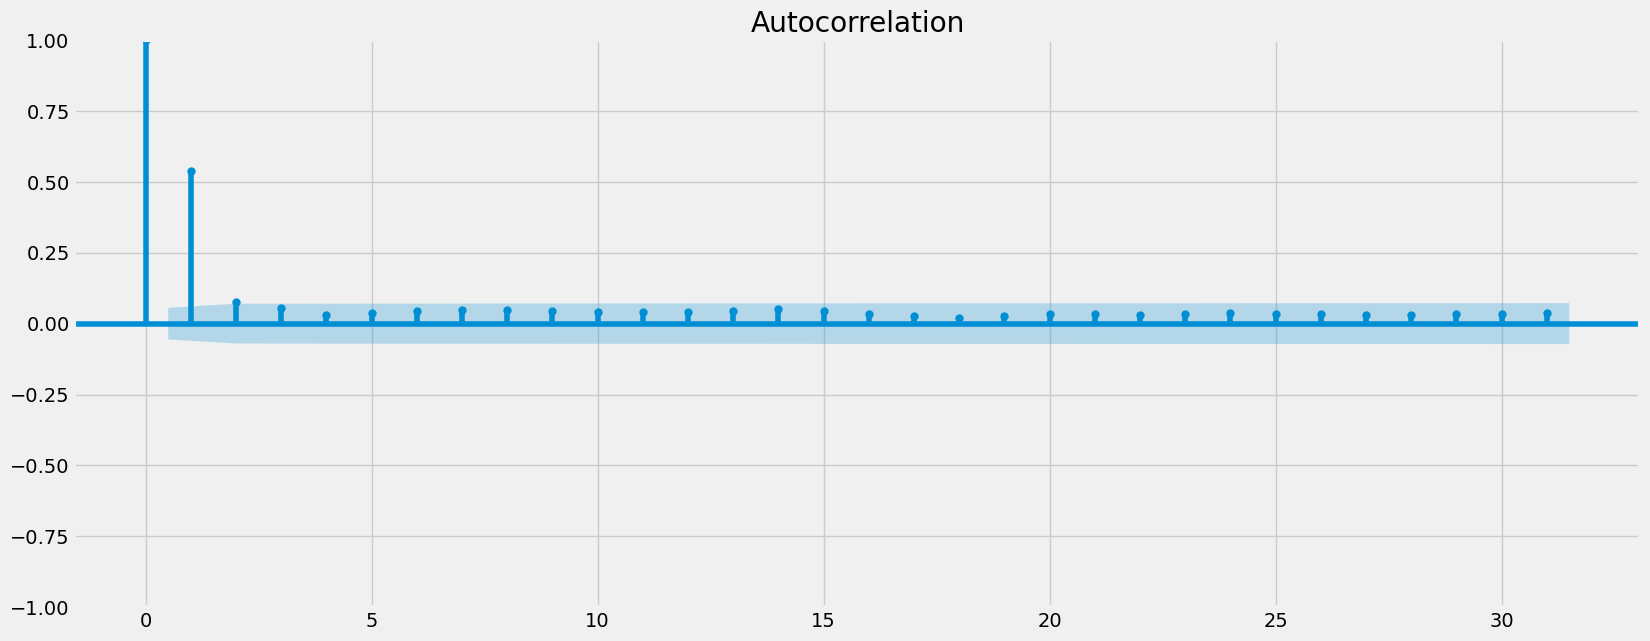

In [49]:
#Plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub_pre)
plt.show()

#### Autocorrelation:  Due to the few number of lines that exist outside the confidence interval (blue-shaded area), we can deduce from this that the data does have stationarity

## 7. Stationarity: Round of Differencing

##### Stationarizing Post Sept 2008 Data

In [50]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff = data_dups_post - data_dups_post.shift(1) 

In [51]:
#Remove the missing values that came about as a result of the differencing.
data_diff.dropna(inplace = True)

In [52]:
data_diff.head()

,Value
datetime,
2008-09-17,65594.0
2008-10-01,67416.0
2008-10-15,145692.0
2008-10-29,81918.0
2008-11-12,241676.0


In [53]:
data_diff.columns

Index(['Value'], dtype='object')

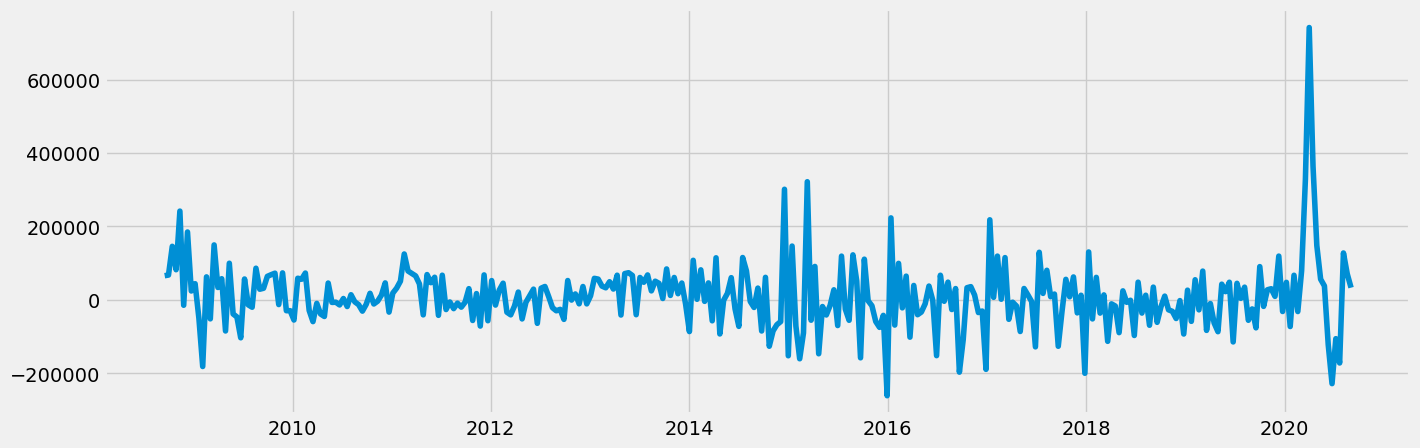

In [54]:
#Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [55]:
#Perform the Dickey-Fuller Test on the new plot
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.696459
p-value                          0.004163
Number of Lags Used             16.000000
Number of Observations Used    296.000000
Critical Value (1%)             -3.452637
Critical Value (5%)             -2.871354
Critical Value (10%)            -2.571999
dtype: float64


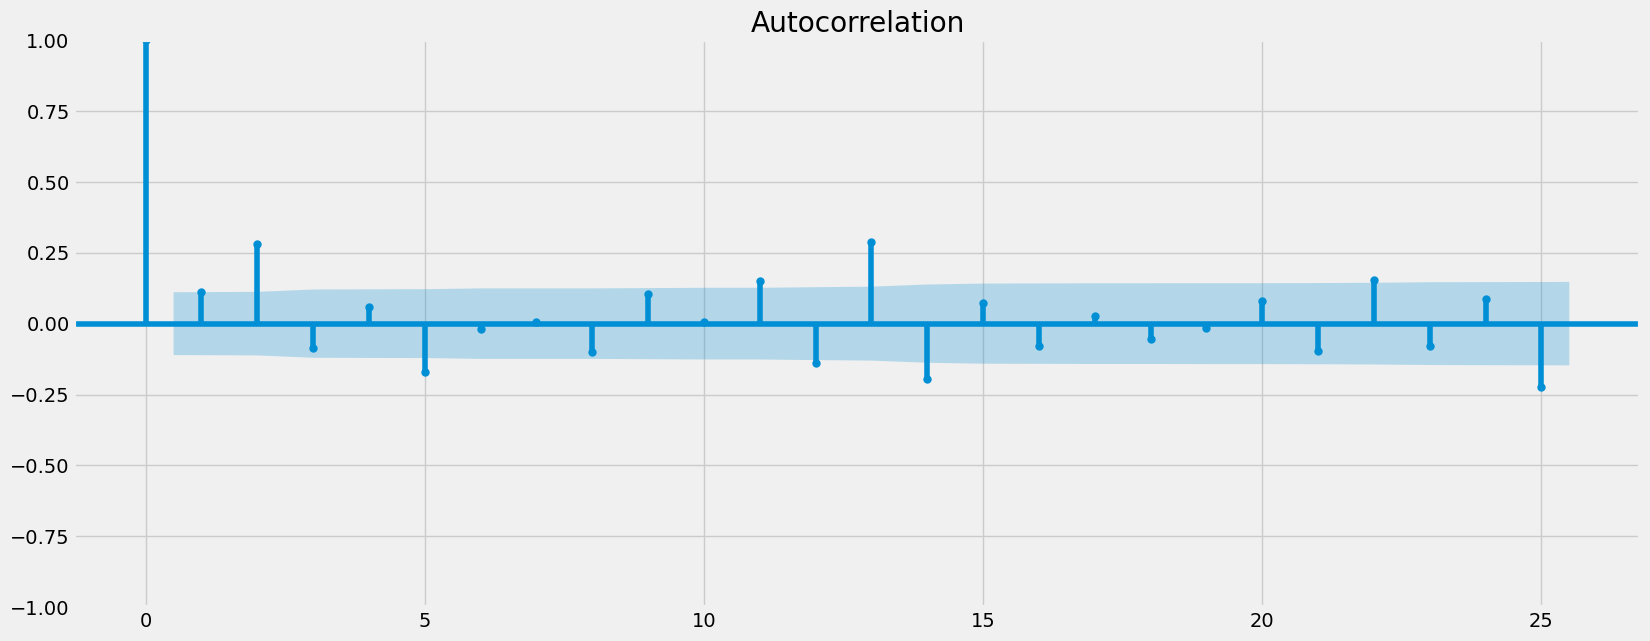

In [56]:
#Perform Autocorrelation on the new data set
plot_acf(data_diff)
plt.show()

#### We can see that the new Test-Statistic is now larger than all the Critical values, so the data now has stationarity.  We can also see this from the Autocorrelation as most of the lines are within the confidence interval